In [18]:
#Importar librerías necesarias
import pandas as pd
import numpy as np
import os
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
#cambiar el directorio actual con chdir
os.chdir('/Users/Pc/Downloads')
import matplotlib.pyplot as plt
# 1) Cargar datos
df = pd.read_csv("delitos_procesados.csv")

In [ ]:
# Normalizar columnas
df['delito'] = df['delito'].str.upper().str.strip()
df['año_mes'] = pd.to_datetime(df['año_mes'], format='%Y-%m')
df['numero_delitos'] = pd.to_numeric(df['numero_delitos'], errors='coerce').fillna(0).astype(int)

# Filtrar delitos de autos
delitos_auto = [
    "ROBO DE VEHÍCULO DE AUTOMOTOR",
    "EN ACCIDENTE DE TRÁNSITO",
    "ROBO DE AUTOPARTES"
]

df_auto = df[df['delito'].isin(delitos_auto)].copy()

# Agregar totales por estado y mes
panel = (df_auto.groupby(['estado','año_mes'], as_index=False)['numero_delitos']
         .sum()
         .rename(columns={'numero_delitos':'delitos_auto'}))

# Selección del estado: mayor volumen EN 2025 (enero–julio), excluyendo "NACIONAL"
mask_periodo = (panel['año_mes'] >= '2025-01-01') & (panel['año_mes'] <= '2025-07-01')

# Excluir "NACIONAL"
panel_estados = panel[mask_periodo & (panel['estado'] != "Nacional")]

top_estado = (panel_estados
              .groupby('estado')['delitos_auto']
              .sum()
              .sort_values(ascending=False)
              .index[0])

print("Estado elegido:", top_estado)

Estado elegido: 09. CDMX


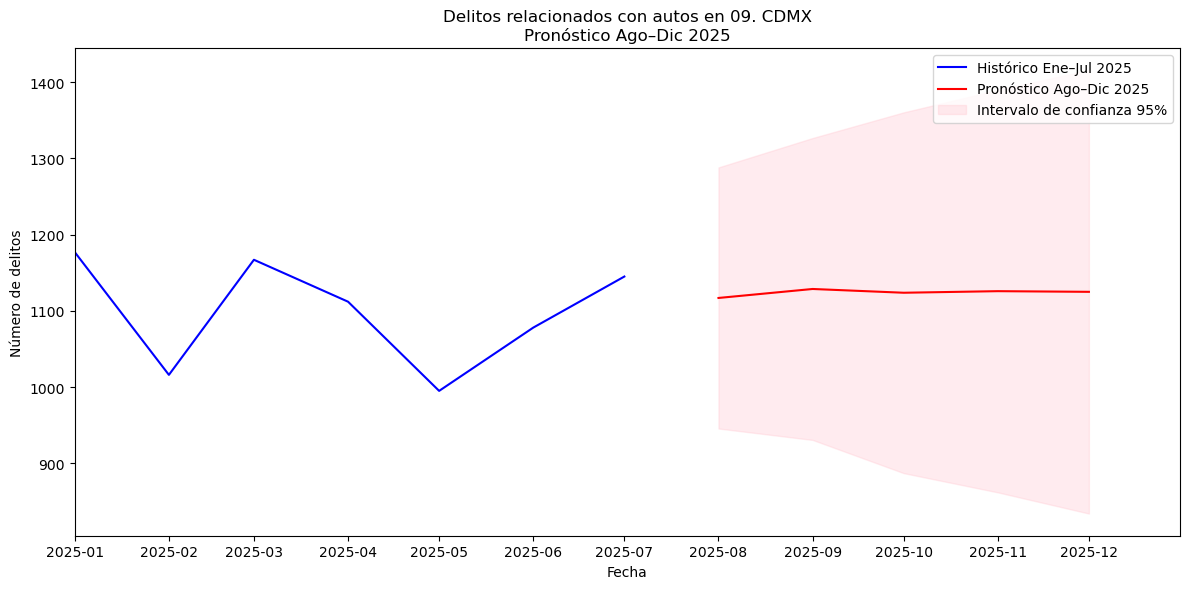

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Serie temporal de enero–julio 2025
serie = (panel[panel['estado'] == top_estado]
         .set_index('año_mes')['delitos_auto']
         .asfreq('MS')  # frecuencia mensual de inicio
         .fillna(0))

train = serie.loc['2025-01':'2025-07']

model = SARIMAX(train, order=(1, 1, 0), 
                seasonal_order=(0, 0, 0, 0), 
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

#Pronóstico agosto–diciembre 2025 (5 pasos)
forecast = res.get_forecast(steps=5)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Asegurar que el índice de predicciones esté correcto (por seguridad)
future_dates = pd.date_range(start='2025-08-01', periods=5, freq='MS')
pred_mean.index = future_dates
conf_int.index = future_dates

# Graficar resultados
plt.figure(figsize=(12, 6))

# Histórico
plt.plot(train.index, train, label="Histórico Ene–Jul 2025", color="blue")

# Pronóstico (Ago–Dic)
plt.plot(pred_mean.index, pred_mean, label="Pronóstico Ago–Dic 2025", color="red")
plt.fill_between(pred_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color="pink", alpha=0.3, label="Intervalo de confianza 95%")

# Ajustar el rango del eje X para mostrar todo 2025
plt.xlim([pd.to_datetime('2025-01-01'), pd.to_datetime('2025-12-31')])

plt.title(f"Delitos relacionados con autos en {top_estado}\nPronóstico Ago–Dic 2025")
plt.xlabel("Fecha")
plt.ylabel("Número de delitos")
plt.legend()
plt.tight_layout()
plt.show()
